# Analysis & Visualizations for Executive Presentation

In [25]:
# Import all modules
import sys
sys.path.insert(0, '..')

# Our modules
from src.data_loader import load_csvs
from src.feature_engineering import build_features
from src.feature_selection import get_XYT, fit_catboost, dr_tau_saved, perm_importance, add_rank, cat_feature_indices
from src.modeling import *  # All model functions
from src.config import *  # All constants

# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print('✓ All imports successful')


✓ All imports successful


In [10]:
# Load Data
df_churn, df_app, df_web, df_claims = load_csvs(data_dir="../data/train/")


[LOAD] Loading from folder: ../data/train/


In [11]:
# ============================================================
# Compute imp_all (Prerequisites for Analysis)
# ============================================================
print("[Setup] Calculating feature importance (imp_all)...")

# 1) Build features
df_all = build_features(df_churn, df_app, df_web, df_claims, web_mode="counts+conc").copy()
X, y, t = get_XYT(df_all)

# Split (Train/Holdout)
strat = (y * 2 + t)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
tr_idx, ho_idx = next(sss.split(np.arange(len(df_all)), strat))
X_tr, y_tr, t_tr = X.iloc[tr_idx].copy(), y[tr_idx], t[tr_idx]
X_ho, y_ho, t_ho = X.iloc[ho_idx].copy(), y[ho_idx], t[ho_idx]

# 2) Fit Models & Permutation Importance (Simplified for Speed)
# Churn
m_churn = fit_catboost(X_tr, y_tr, X_ho, y_ho, seed=SEED + 100)
imp_churn = pd.DataFrame({"feature": X_tr.columns, "gain": m_churn.get_feature_importance()}).sort_values("gain", ascending=False)
imp_churn["rank_churn"] = np.arange(len(imp_churn))

# Propensity
m_prop = fit_catboost(X_tr, t_tr, X_ho, t_ho, seed=SEED + 200)
imp_prop = pd.DataFrame({"feature": X_tr.columns, "gain": m_prop.get_feature_importance()}).sort_values("gain", ascending=False)
imp_prop["rank_prop"] = np.arange(len(imp_prop))

# Uplift Proxy (Simplified)
# Fit nuisance
mask0_tr = (t_tr == 0)
mask1_tr = (t_tr == 1)
mu0 = fit_catboost(X_tr.loc[mask0_tr], y_tr[mask0_tr], X_ho.loc[t_ho == 0], y_ho[t_ho == 0], seed=SEED + 400)
mu1 = fit_catboost(X_tr.loc[mask1_tr], y_tr[mask1_tr], X_ho.loc[t_ho == 1], y_ho[t_ho == 1], seed=SEED + 500)
e_model = fit_catboost(X_tr, t_tr, X_ho, t_ho, seed=SEED + 300)

tau_saved_ho, _, _, _ = dr_tau_saved(mu0, mu1, e_model, X_ho, y_ho, t_ho)
uplift_label_ho = (tau_saved_ho > 0).astype(int)

# Proxy Model
m_proxy = fit_catboost(X_ho, uplift_label_ho, X_ho, uplift_label_ho, seed=SEED+600) # Quick fit on holdout
imp_proxy = pd.DataFrame({"feature": X_ho.columns, "gain": m_proxy.get_feature_importance()}).sort_values("gain", ascending=False)
imp_proxy["rank_uplift"] = np.arange(len(imp_proxy))

# Merge
imp_all = imp_churn[["feature", "rank_churn"]].merge(imp_prop[["feature", "rank_prop"]], on="feature")
imp_all = imp_all.merge(imp_proxy[["feature", "rank_uplift"]], on="feature")
imp_all["rank_mean"] = imp_all[["rank_churn", "rank_prop", "rank_uplift"]].mean(axis=1)
imp_all = imp_all.sort_values("rank_mean").reset_index(drop=True)

print("imp_all computed.")
display(imp_all.head())


[Setup] Calculating feature importance (imp_all)...


/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:465: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[name] = feature_df["member_id"].map(ser).fillna(0)
/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:467: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df["wellco_engagement"] = (


0:	learn: 0.6796536	test: 0.6798636	best: 0.6798636 (0)	total: 22.6ms	remaining: 1m 7s
200:	learn: 0.4493217	test: 0.4772553	best: 0.4772553 (200)	total: 3.68s	remaining: 51.2s
400:	learn: 0.4321097	test: 0.4773671	best: 0.4765854 (304)	total: 7.37s	remaining: 47.8s
bestTest = 0.4765854492
bestIteration = 304
Shrink model to first 305 iterations.
0:	learn: 0.6902795	test: 0.6902109	best: 0.6902109 (0)	total: 19.4ms	remaining: 58.1s
200:	learn: 0.6206039	test: 0.6396674	best: 0.6395831 (187)	total: 3.7s	remaining: 51.5s
bestTest = 0.6395831299
bestIteration = 187
Shrink model to first 188 iterations.
0:	learn: 0.6796395	test: 0.6800530	best: 0.6800530 (0)	total: 17.1ms	remaining: 51.2s
200:	learn: 0.4473224	test: 0.4853663	best: 0.4845974 (171)	total: 3.23s	remaining: 44.9s
bestTest = 0.484597375
bestIteration = 171
Shrink model to first 172 iterations.
0:	learn: 0.6789799	test: 0.6795554	best: 0.6795554 (0)	total: 16.9ms	remaining: 50.7s
200:	learn: 0.4066659	test: 0.4652564	best: 0.46

,feature,rank_churn,rank_prop,rank_uplift,rank_mean
0,tenure_days_at_obs_start,3,2,3,2.666667
1,risk_uplift_proxy,4,16,0,6.666667
2,rfm_norm,5,14,2,7.000000
3,sessions_per_active_day,9,3,11,7.666667
4,web_other_visits,8,8,10,8.666667


[Run] DEVICE: cuda
[Run] FEATURE_TOPK_LIST: [20, 40, 60, 80, 100]
[Run] CHURN_GATE_ALPHAS: [0.2, 0.6, 1.0, 1.2, 1.5]
[Run] MODELS_TO_RUN: ['A_logreg_tlearner', 'B_boost_tlearner', 'C_mlp_twohead']
[DF] (10000, 105) | churn rate: 0.2021 | outreach rate: 0.3984

[Feature tuning] K_features=20 | n_used=20 | X shape=(10000, 20)

[Propensity] computing OOF ê(x) ...


/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:465: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[name] = feature_df["member_id"].map(ser).fillna(0)
/home/weizyuv/vi_labs_assignment/notebooks/../src/feature_engineering.py:467: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df["wellco_engagement"] = (


[Propensity] ê(x) mean: 0.4934184293703531 min/max: 0.0905077739197323 0.91154542344165
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 2/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 3/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 4/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 5/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



[Feature tuning] K_features=40 | n_used=40 | X shape=(10000, 40)

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.49330993299557485 min/max: 0.08282754866085068 0.9198878036851325
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 2/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 3/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 4/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 5/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



[Feature tuning] K_features=60 | n_used=60 | X shape=(10000, 60)

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.49303996479704393 min/max: 0.08511950938828071 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 2/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 3/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 4/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 5/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



[Feature tuning] K_features=80 | n_used=80 | X shape=(10000, 80)

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.49285314688385967 min/max: 0.08281633526681534 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:42:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 2/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 3/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 4/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 5/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



[Feature tuning] K_features=100 | n_used=99 | X shape=(10000, 99)

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.49286162291199187 min/max: 0.08414676662025246 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 2/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 3/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 4/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



FOLD 5/5 | train=8000 test=2000


/home/weizyuv/.conda/envs/my_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [17:43:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



=== OOF UPLIFT SUMMARY (feature tuning + assignment metrics only; sorted by AUQC) ===


,K_features,n_used,model,variant,OOF_AUQC,overall_uplift_all,Uplift10,Saved10,Uplift30,Saved30,n_pos(score>0),n_guard(score>0.005)
0,80,80,C_mlp_twohead,RAND,0.118685,0.038842,0.047092,47.091688,0.057532,172.596629,5076,5066
1,100,99,A_logreg_tlearner,CHURN_INTENSITY=1.5,0.116748,0.038534,0.056479,56.478705,0.070180,210.541419,6703,5997
2,100,99,A_logreg_tlearner,CHURN_INTENSITY=1.2,0.114301,0.038534,0.067659,67.659485,0.066572,199.716405,6703,6199
3,100,99,A_logreg_tlearner,CHURN_INTENSITY=1.0,0.110656,0.038534,0.071022,71.021572,0.065915,197.745044,6703,6307
4,60,60,A_logreg_tlearner,CHURN_INTENSITY=1.5,0.108926,0.039301,0.060044,60.043634,0.066843,200.529738,7022,6254
...,...,...,...,...,...,...,...,...,...,...,...,...
115,60,60,B_boost_tlearner,CHURN_INTENSITY=0.6,-0.079001,0.039301,0.053829,53.828707,0.037156,111.468708,6923,6122
116,60,60,B_boost_tlearner,CHURN_INTENSITY=1.0,-0.081190,0.039301,0.056565,56.564562,0.027905,83.715737,6923,5261
117,60,60,B_boost_tlearner,CHURN_INTENSITY=1.2,-0.083006,0.039301,0.052001,52.000741,0.030983,92.949007,6923,4713
118,60,60,B_boost_tlearner,CHURN_INTENSITY=1.5,-0.084453,0.039301,0.045889,45.889123,0.030618,91.852950,6923,3904



=== Best variant per model (by AUQC) ===


,K_features,n_used,model,variant,OOF_AUQC,overall_uplift_all,Uplift10,Saved10,Uplift30,Saved30,n_pos(score>0),n_guard(score>0.005)
0,80,80,C_mlp_twohead,RAND,0.118685,0.038842,0.047092,47.091688,0.057532,172.596629,5076,5066
1,100,99,A_logreg_tlearner,CHURN_INTENSITY=1.5,0.116748,0.038534,0.056479,56.478705,0.070180,210.541419,6703,5997
2,20,20,B_boost_tlearner,RAND,0.079094,0.038868,0.053841,53.840595,0.063507,190.521901,5043,5029



=== n(k) tables for TOP 6 configurations (k=c/v break-even uplift threshold) ===

--- 1) (80, 'C_mlp_twohead', 'RAND') | AUQC=0.1187 | Saved10=47.09 | Saved30=172.60 ---


,k_ratio(c/v),n(k)
0,0.000,5076
1,0.002,5073
2,0.005,5066
3,0.010,5045
4,0.020,5006
5,0.050,4885
6,0.100,4680
7,0.200,4285



--- 2) (100, 'A_logreg_tlearner', 'CHURN_INTENSITY=1.5') | AUQC=0.1167 | Saved10=56.48 | Saved30=210.54 ---


,k_ratio(c/v),n(k)
0,0.000,6703
1,0.002,6431
2,0.005,5997
3,0.010,5407
4,0.020,4308
5,0.050,2157
6,0.100,613
7,0.200,42



--- 3) (100, 'A_logreg_tlearner', 'CHURN_INTENSITY=1.2') | AUQC=0.1143 | Saved10=67.66 | Saved30=199.72 ---


,k_ratio(c/v),n(k)
0,0.000,6703
1,0.002,6511
2,0.005,6199
3,0.010,5733
4,0.020,4828
5,0.050,2700
6,0.100,876
7,0.200,71



--- 4) (100, 'A_logreg_tlearner', 'CHURN_INTENSITY=1.0') | AUQC=0.1107 | Saved10=71.02 | Saved30=197.75 ---


,k_ratio(c/v),n(k)
0,0.000,6703
1,0.002,6549
2,0.005,6307
3,0.010,5893
4,0.020,5116
5,0.050,3072
6,0.100,1128
7,0.200,109



--- 5) (60, 'A_logreg_tlearner', 'CHURN_INTENSITY=1.5') | AUQC=0.1089 | Saved10=60.04 | Saved30=200.53 ---


,k_ratio(c/v),n(k)
0,0.000,7022
1,0.002,6716
2,0.005,6254
3,0.010,5500
4,0.020,4191
5,0.050,1729
6,0.100,339
7,0.200,15



--- 6) (100, 'A_logreg_tlearner', 'CHURN_INTENSITY=0.6') | AUQC=0.1052 | Saved10=80.32 | Saved30=173.23 ---


,k_ratio(c/v),n(k)
0,0.000,6703
1,0.002,6598
2,0.005,6450
3,0.010,6135
4,0.020,5610
5,0.050,3880
6,0.100,1849
7,0.200,241


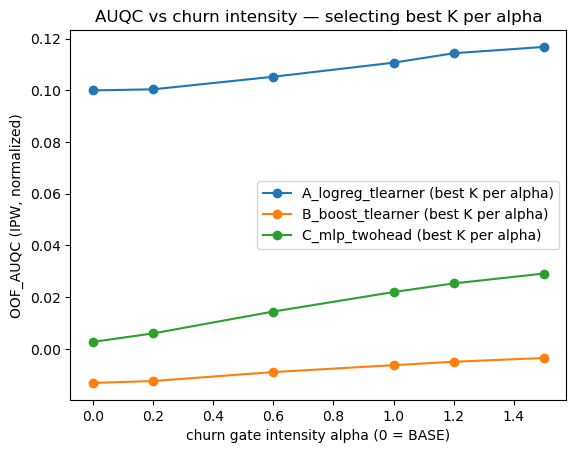


[Best overall pick]
  best_key = (80, 'C_mlp_twohead', 'RAND') | AUQC=0.1187


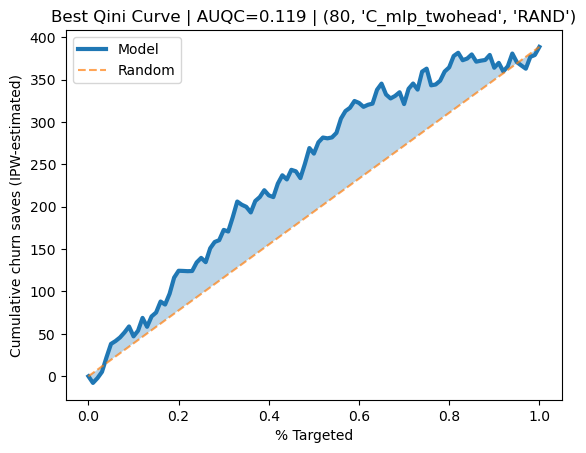


[Recompute best_score] running OOF (ONLY best model) for best K to reconstruct score thresholds...

[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.49285314688385967 min/max: 0.08281633526681534 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000

FOLD 2/5 | train=8000 test=2000

FOLD 3/5 | train=8000 test=2000

FOLD 4/5 | train=8000 test=2000

FOLD 5/5 | train=8000 test=2000


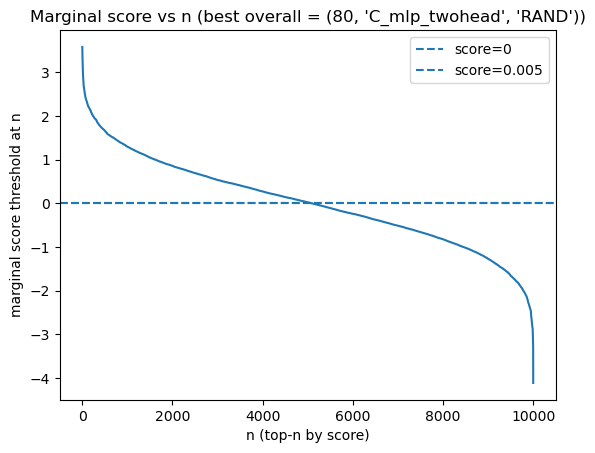

  n_pos (score>0): 5076
  n_guard (score>0.005): 5066

=== Uplift@K report (best overall) ===


,K%,n,uplift,saved,n0_eff,n1_eff,n_t0y0,n_t0y1,n_t1y0,n_t1y1
0,10,1000,0.047092,47.091688,1240.058480,793.440599,487,118,323,72
1,30,3000,0.057532,172.596629,3663.558759,2410.977588,1411,382,981,226


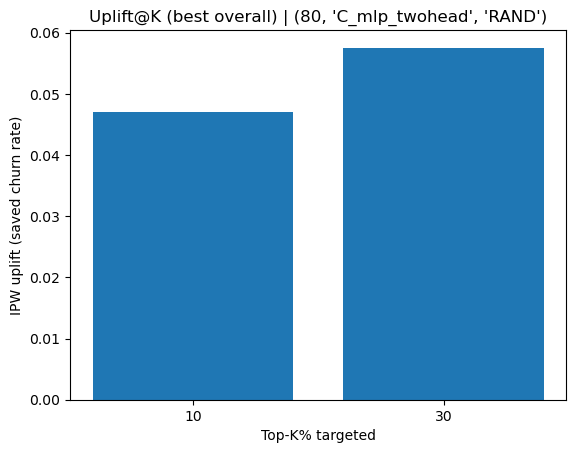


=== Top-3 winners plots ===


,K_features,n_used,model,variant,OOF_AUQC,overall_uplift_all,Uplift10,Saved10,Uplift30,Saved30,n_pos(score>0),n_guard(score>0.005)
0,80,80,C_mlp_twohead,RAND,0.118685,0.038842,0.047092,47.091688,0.057532,172.596629,5076,5066
1,100,99,A_logreg_tlearner,CHURN_INTENSITY=1.5,0.116748,0.038534,0.056479,56.478705,0.070180,210.541419,6703,5997
2,100,99,A_logreg_tlearner,CHURN_INTENSITY=1.2,0.114301,0.038534,0.067659,67.659485,0.066572,199.716405,6703,6199



[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.4933519440325963 min/max: 0.08724420814610699 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000

FOLD 2/5 | train=8000 test=2000

FOLD 3/5 | train=8000 test=2000

FOLD 4/5 | train=8000 test=2000

FOLD 5/5 | train=8000 test=2000


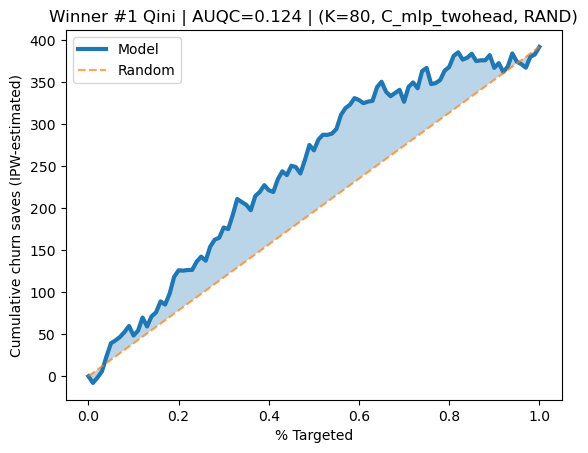

,K%,n,uplift,saved,n0_eff,n1_eff,n_t0y0,n_t0y1,n_t1y0,n_t1y1
0,10,1000,0.048434,48.433578,1240.944271,792.468217,487,118,323,72
1,30,3000,0.059022,177.067025,3658.683325,2406.987081,1411,382,981,226


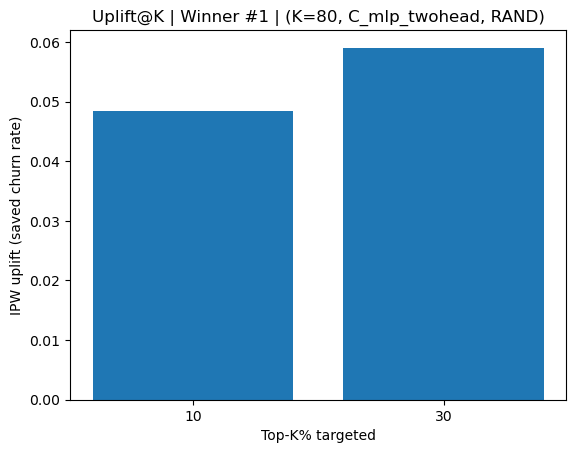


[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.49236722841858643 min/max: 0.07904357949791528 0.999
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000

FOLD 2/5 | train=8000 test=2000

FOLD 3/5 | train=8000 test=2000

FOLD 4/5 | train=8000 test=2000

FOLD 5/5 | train=8000 test=2000


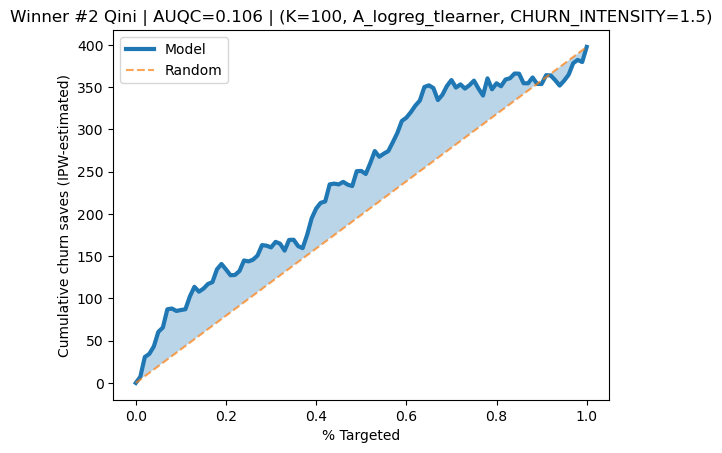

,K%,n,uplift,saved,n0_eff,n1_eff,n_t0y0,n_t0y1,n_t1y0,n_t1y1
0,10,1000,0.086257,86.256653,1229.50184,779.869431,444,162,312,82
1,30,3000,0.053444,160.331434,3702.06166,2373.196498,1396,435,920,249


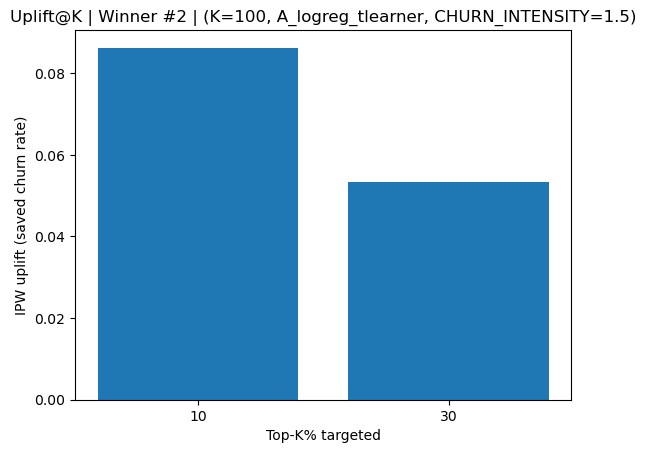


[Propensity] computing OOF ê(x) ...
[Propensity] ê(x) mean: 0.4929533810241937 min/max: 0.08566339393082022 0.8827282528701652
[Boost] backend: xgboost

FOLD 1/5 | train=8000 test=2000

FOLD 2/5 | train=8000 test=2000

FOLD 3/5 | train=8000 test=2000

FOLD 4/5 | train=8000 test=2000

FOLD 5/5 | train=8000 test=2000


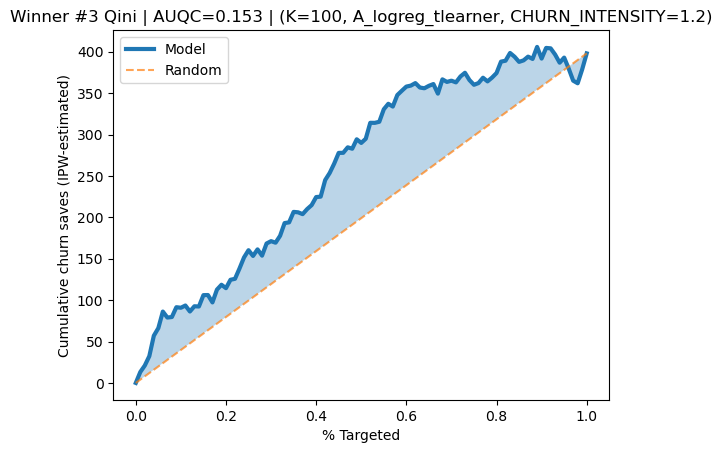

,K%,n,uplift,saved,n0_eff,n1_eff,n_t0y0,n_t0y1,n_t1y0,n_t1y1
0,10,1000,0.090781,90.781271,1259.237932,756.283835,455,164,307,74
1,30,3000,0.057066,171.197380,3654.571514,2393.248786,1406,424,937,233


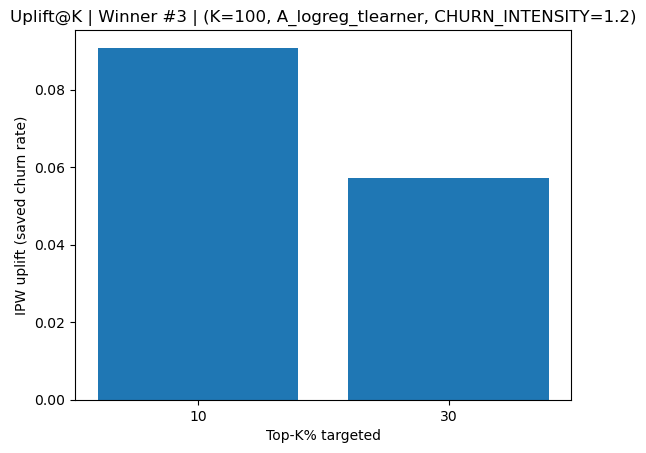

In [12]:
# ============================================================
# CELL 3B — USAGE / RUN (v6.2)
#   Requires:
#     - build_features(...) available
#     - df_final OR df_churn/df_app/df_web/df_claims available
#     - imp_all already computed (recommended) for feature ranking
# ============================================================

from IPython.display import display

# Reset random seeds for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
print("[Run] DEVICE:", DEVICE)
print("[Run] FEATURE_TOPK_LIST:", FEATURE_TOPK_LIST)
print("[Run] CHURN_GATE_ALPHAS:", CHURN_GATE_ALPHAS)
print("[Run] MODELS_TO_RUN:", MODELS_TO_RUN)

# ---------------------------
# Load DF
# ---------------------------
if "df_final" in globals():
    DF_ALL = df_final.copy()
else:
    web_mode = "counts+conc"
    DF_ALL = build_features(df_churn, df_app, df_web, df_claims, web_mode=web_mode).copy()

print("[DF]", DF_ALL.shape,
      "| churn rate:", float(DF_ALL["churn"].mean()),
      "| outreach rate:", float(DF_ALL["outreach"].mean()))

# ---------------------------
# Prepare ranked features
# ---------------------------
X_full, y, t = get_XYT(DF_ALL)
ranked_features = get_ranked_features_from_imp_all(X_full, imp_all=imp_all)

# ---------------------------
# Run feature tuning
# ---------------------------
rows = []
curves_ipw = {}
n_tables = {}

for Kfeat in FEATURE_TOPK_LIST:
    X_df, n_used = select_topk_X(X_full, ranked_features, Kfeat)

    print("\n" + "="*95)
    print(f"[Feature tuning] K_features={Kfeat} | n_used={n_used} | X shape={X_df.shape}")
    print("="*95)

    e_hat, oof_tau, oof_p0, oof_p1 = run_oof_uplift_models_X(X_df, y, t)

    for model_name in MODELS_TO_RUN:
        base_tau = oof_tau[model_name]
        base_p0  = oof_p0[model_name]

        # IMPORTANT: make RAND deterministic per (K, model)
        variants = build_score_variants(
            base_tau, base_p0, CHURN_GATE_ALPHAS,
            add_risk_baseline=True,
            add_random_baseline=True,
            seed=SEED + 10000 + int(Kfeat) * 31 + stable_hash_int(model_name, 997)
        )

        for variant_name, score in variants:
            key = (int(Kfeat), model_name, variant_name)

            xs, model_curve, rand_curve, auqc, auqc_raw, overall_uplift = \
                qini_curve_and_auqc_ipw(y, t, e_hat, score, n_bins=100)

            # report some K points (your K_FRACS list is available, but we keep 10% and 30% here for consistency)
            u10 = uplift_at_frac_ipw(y, t, e_hat, score, frac=0.10)
            u30 = uplift_at_frac_ipw(y, t, e_hat, score, frac=0.30)

            rows.append({
                "K_features": int(Kfeat),
                "n_used": int(n_used),

                "model": model_name,
                "variant": variant_name,
                "OOF_AUQC": float(auqc),
                "overall_uplift_all": float(overall_uplift),

                "Uplift10": float(u10["uplift"]),
                "Saved10": float(u10["uplift"] * u10["k_n"]),
                "Uplift30": float(u30["uplift"]),
                "Saved30": float(u30["uplift"] * u30["k_n"]),

                "n_pos(score>0)": int(n_default_positive(score, eps=0.0)),
                f"n_guard(score>{EPS_GUARD})": int(n_default_positive(score, eps=EPS_GUARD)),
            })

            n_by_k = [{"k_ratio(c/v)": k, "n(k)": n_by_ratio_threshold(score, k)} for k in K_RATIO_GRID]
            n_tables[key] = pd.DataFrame(n_by_k)

            curves_ipw[key] = (xs, model_curve, rand_curve)

df_summary_ipw = pd.DataFrame(rows).sort_values("OOF_AUQC", ascending=False).reset_index(drop=True)

print("\n=== OOF UPLIFT SUMMARY (feature tuning + assignment metrics only; sorted by AUQC) ===")
display(df_summary_ipw)

# ---------------------------
# Best per model
# ---------------------------
print("\n=== Best variant per model (by AUQC) ===")
best_per_model = (df_summary_ipw
                  .sort_values(["model","OOF_AUQC"], ascending=[True, False])
                  .groupby("model").head(1)
                  .sort_values("OOF_AUQC", ascending=False)
                  .reset_index(drop=True))
display(best_per_model)

# ---------------------------
# n(k) tables for top 6
# ---------------------------
print("\n=== n(k) tables for TOP 6 configurations (k=c/v break-even uplift threshold) ===")
for i in range(min(6, len(df_summary_ipw))):
    r = df_summary_ipw.iloc[i]
    key = (int(r["K_features"]), r["model"], r["variant"])
    print(f"\n--- {i+1}) {key} | AUQC={r['OOF_AUQC']:.4f} | Saved10={r['Saved10']:.2f} | Saved30={r['Saved30']:.2f} ---")
    display(n_tables[key])

# ---------------------------
# Plot 1: AUQC vs churn intensity for each model (best K per alpha)
#   (Skip baselines RISK_p0/RAND because they are not "alpha")
# ---------------------------
plt.figure()
for m in MODELS_TO_RUN:
    d = df_summary_ipw[(df_summary_ipw["model"] == m)].copy()
    d = d[d["variant"].isin(["BASE"] + [f"CHURN_INTENSITY={a}" for a in CHURN_GATE_ALPHAS])]
    d["alpha"] = d["variant"].apply(parse_alpha)

    d_best = (d.sort_values(["alpha","OOF_AUQC"], ascending=[True, False])
               .groupby("alpha").head(1)
               .sort_values("alpha"))

    plt.plot(d_best["alpha"], d_best["OOF_AUQC"], marker="o", label=f"{m} (best K per alpha)")

plt.xlabel("churn gate intensity alpha (0 = BASE)")
plt.ylabel("OOF_AUQC (IPW, normalized)")
plt.title("AUQC vs churn intensity — selecting best K per alpha")
plt.legend()
plt.show()

# ---------------------------
# Best overall config
# ---------------------------
best_overall = df_summary_ipw.iloc[0]
best_key = (int(best_overall["K_features"]), best_overall["model"], best_overall["variant"])
print("\n[Best overall pick]")
print(f"  best_key = {best_key} | AUQC={float(best_overall['OOF_AUQC']):.4f}")

# ---------------------------
# Plot 2: Qini curve — best overall (with fill)
# ---------------------------
xs, model_curve, rand_curve = curves_ipw[best_key]
plot_qini_with_fill(xs, model_curve, rand_curve, title=f"Best Qini Curve | AUQC={best_overall['OOF_AUQC']:.3f} | {best_key}")

# ---------------------------
# Plot 3: Marginal score threshold vs n (best overall)
#   (re-run OOF ONLY for the best model to reconstruct score)
# ---------------------------
K_best = int(best_overall["K_features"])
m_best = best_overall["model"]
v_best = best_overall["variant"]

X_best_df, _ = select_topk_X(X_full, ranked_features, K_best)

print("\n[Recompute best_score] running OOF (ONLY best model) for best K to reconstruct score thresholds...")
e_hat_best, oof_tau_best, oof_p0_best, _ = run_oof_uplift_models_X(X_best_df, y, t, models_to_run=[m_best])

base_tau = oof_tau_best[m_best].copy()
base_p0  = np.clip(oof_p0_best[m_best].copy(), 1e-6, 1 - 1e-6)

if v_best == "BASE":
    best_score = base_tau
elif v_best.startswith("CHURN_INTENSITY="):
    alpha = parse_alpha(v_best)
    best_score = base_tau * np.power(base_p0, float(alpha))
elif v_best == "RISK_p0":
    best_score = base_p0
else:
    # RAND: reconstruct deterministically
    rng = np.random.default_rng(SEED + 10000 + int(K_best) * 31 + stable_hash_int(m_best, 997))
    best_score = rng.standard_normal(len(base_tau)).astype(float)

score_sorted = np.sort(best_score)[::-1]
plt.figure()
plt.plot(np.arange(1, len(score_sorted)+1), score_sorted)
plt.axhline(0.0, linestyle="--", label="score=0")
plt.axhline(EPS_GUARD, linestyle="--", label=f"score={EPS_GUARD}")
plt.xlabel("n (top-n by score)")
plt.ylabel("marginal score threshold at n")
plt.title(f"Marginal score vs n (best overall = {best_key})")
plt.legend()
plt.show()

print(f"  n_pos (score>0): {n_default_positive(best_score, eps=0.0)}")
print(f"  n_guard (score>{EPS_GUARD}): {n_default_positive(best_score, eps=EPS_GUARD)}")

# ---------------------------
# Extra winner plot: Uplift@K (table + bar) for best overall
# ---------------------------
ks_for_exec = (0.10, 0.30)
df_k = uplift_k_report_ipw(y, t, e_hat_best, best_score, fracs=ks_for_exec)
print("\n=== Uplift@K report (best overall) ===")
display(df_k)

plt.figure()
plt.bar(df_k["K%"].astype(str), df_k["uplift"].values)
plt.xlabel("Top-K% targeted")
plt.ylabel("IPW uplift (saved churn rate)")
plt.title(f"Uplift@K (best overall) | {best_key}")
plt.show()

# ---------------------------
# Bonus: Top-3 winners (Qini + Uplift@K)
#   (recompute OOF only for each winner’s model to get its exact score)
# ---------------------------
TOP_W = 3
top_winners = df_summary_ipw.head(TOP_W).copy()

print(f"\n=== Top-{TOP_W} winners plots ===")
display(top_winners)

for i in range(min(TOP_W, len(top_winners))):
    r = top_winners.iloc[i]
    K_w = int(r["K_features"])
    m_w = r["model"]
    v_w = r["variant"]

    X_w_df, _ = select_topk_X(X_full, ranked_features, K_w)
    e_hat_w, oof_tau_w, oof_p0_w, _ = run_oof_uplift_models_X(X_w_df, y, t, models_to_run=[m_w], seed=SEED + 777 + i)

    tau_w = oof_tau_w[m_w]
    p0_w  = np.clip(oof_p0_w[m_w], 1e-6, 1 - 1e-6)

    if v_w == "BASE":
        score_w = tau_w
    elif v_w.startswith("CHURN_INTENSITY="):
        score_w = tau_w * np.power(p0_w, float(parse_alpha(v_w)))
    elif v_w == "RISK_p0":
        score_w = p0_w
    else:
        rng = np.random.default_rng(SEED + 10000 + int(K_w) * 31 + stable_hash_int(m_w, 997))
        score_w = rng.standard_normal(len(tau_w)).astype(float)

    xs, mc, rc, auqc, _, _ = qini_curve_and_auqc_ipw(y, t, e_hat_w, score_w, n_bins=100)
    plot_qini_with_fill(xs, mc, rc, title=f"Winner #{i+1} Qini | AUQC={auqc:.3f} | (K={K_w}, {m_w}, {v_w})")

    df_kw = uplift_k_report_ipw(y, t, e_hat_w, score_w, fracs=ks_for_exec)
    display(df_kw)

    plt.figure()
    plt.bar(df_kw["K%"].astype(str), df_kw["uplift"].values)
    plt.xlabel("Top-K% targeted")
    plt.ylabel("IPW uplift (saved churn rate)")
    plt.title(f"Uplift@K | Winner #{i+1} | (K={K_w}, {m_w}, {v_w})")
    plt.show()


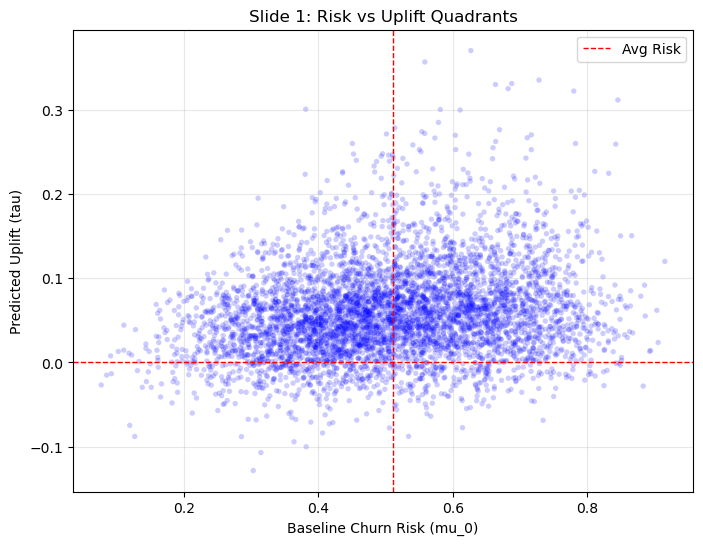

In [13]:

# ============================================================
# Slide 1: Risk x Uplift Matrix
# ============================================================
m_best = best_overall["model"]
tau_plot = oof_tau_best[m_best]
risk_plot = oof_p0_best[m_best]

plt.figure(figsize=(8, 6))
# Subsample for speed/clarity if needed
idx_sample = np.random.choice(len(tau_plot), min(5000, len(tau_plot)), replace=False)
plt.scatter(risk_plot[idx_sample], tau_plot[idx_sample], alpha=0.2, s=15, c='blue', edgecolors='none')
plt.xlabel("Baseline Churn Risk (mu_0)")
plt.ylabel("Predicted Uplift (tau)")
plt.title("Slide 1: Risk vs Uplift Quadrants")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.axvline(risk_plot.mean(), color='red', linestyle='--', linewidth=1, label='Avg Risk')
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('../outputs/figures/slide1_risk_uplift.png')
plt.show()


Top 15 Features by Mean Rank


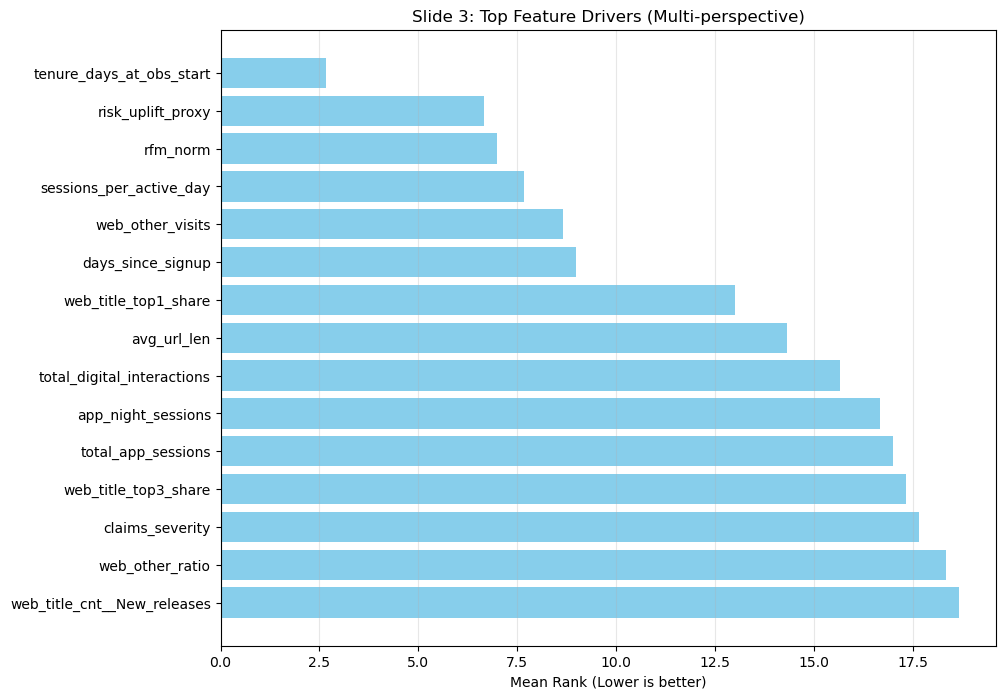

In [14]:

# ============================================================
# Slide 3: Feature Importance (Top Features)
# ============================================================
print("Top 15 Features by Mean Rank")
top_features = imp_all.head(15).copy()
top_features = top_features.sort_values("rank_mean", ascending=False) # Invert for plotting

plt.figure(figsize=(10, 8))
plt.barh(top_features["feature"], top_features["rank_mean"], color='skyblue')
plt.xlabel("Mean Rank (Lower is better)")
plt.title("Slide 3: Top Feature Drivers (Multi-perspective)")
plt.grid(axis='x', alpha=0.3)
plt.savefig('../outputs/figures/slide3_feature_importance.png')
plt.show()
